# Naive Bayes classifier for Fake News recognition

## Libraries

In [1]:
suppressMessages({
library(tokenizers)
library(stopwords)
library(tibble)
library(ggplot2)
library(tidyverse)
library(textstem) # for 'lemmatize_strings' function
library(dplyr)
library(caret) # confusion matrix    
})

## Functions

### Training

In [2]:
TokenizeDF <- function(data){
    # tokenize_words returns a list of one element from a given string or list of strings; stopwords removes
    # the stopwords in English (en).

    # additional stop words
    stopwords_add <- c("im", "youre", "hes", "shes", "its", "theyre", "ive", "youve", "weve", "theyve", "id", "youd", "hed", "wed",
           "theyd", "youll", "theyll", "isnt", "arent", "wasnt", "werent", "hasnt", "havent", "hadnt",
           "doesnt", "dont", "didnt", "wont", "wouldnt", "shant", "shouldnt", "cant", "cannot", "couldnt", "mustnt", "lets", "thats",
           "whos", "whats", "heres", "theres", "whens", "wheres", "whys", "hows")
    # Re-define Text column
    ## remove stopwords
    data$Text <- tokenize_words(data$Text, stopwords = c(stopwords::stopwords("en"), stopwords_add))
    # Unnest Text and Text_Tag
    data_un <- data %>% unnest(Text)
    ## lemmatize (reduction of the words to their root form (e.g. says -> say))
    data_un$Text <- lemmatize_strings(data_un$Text)
    ## remove numbers
    data_un$Text <- gsub("\\d", "", data_un$Text)
    ## remove special characters
    data_un$Text <- gsub("[^[:alnum:]]", "", data_un$Text)
    ## remove strings of length 1
    data_un$Text <- gsub("\\b\\w{1}\\b", "", data_un$Text)
    ## ignore white rows
    data_un <- data_un[!data_un$Text=='',]
    ## remove NA
    data_un <- na.omit(data_un)
    
    return(data_un)
}

ExtractVocabulary <- function(data_un){
    return(unique(data_un$Text))
}

Priors <- function(data){
    # returns priors (Nc/N) for each class in a dataframe
    N <- nrow(data)
    counting <- data %>% group_by(Labels) %>% summarise(prior=n())
    counting$prior <- counting$prior/N
    return(counting)
}

CondProb <- function(data_un, V){
    # compute a dataframe with the counting of each token for each class and return a dataframe with the condprob
    # with for each row the condprobs for each class (corresponding to the columns)
    
    ## counting each token for each class
    T_ct <- data_un %>% group_by(Labels) %>% count(Text) 
    ## Vocabulary and |V|=B
    B <- length(V)
    ## labels and their number
    C <- sort(unique(data_un$Labels))
    numC <- length(C)
    ## denominators (per class) of the condprob
    denoms <- T_ct %>% group_by(Labels) %>% summarise(sum.over.t = sum(n))
    denoms$sum.over.t <- denoms$sum.over.t + B
    
    ## construction of the CondProb matrix
    ### initialize an empty matrix
    M <- matrix(0,nrow=B,ncol=numC)
    ### cycle on the columns (classes) and the rows (tokens)
    for (c in 1:numC){
        for (t in 1:B){
            # in case of T_ct = 0 (if there is not the element tc of the matrix T_ct)
            tmp <- T_ct[T_ct$Text==V[t] & T_ct$Labels==C[c],]$n
            tmp <- ifelse(length(tmp) == 0, 0, tmp)
            
            M[t,c] <- (tmp + 1)/denoms[denoms$Labels == C[c],]$sum.over.t
        }
    }
    ### add the tokens coloumn and convert that matrix into a dataframe
    condprob <- data.frame(cbind(V,M), check.names = FALSE)
    column_names <- c("Token", C)
    names(condprob) <- column_names
    ### convert the columns as numeric
    for (c in 2:(numC+1)){
        condprob[,c] <- as.numeric(condprob[,c])
    }
    
    return(condprob)
}

### Prediction

In [3]:
ExtractTokensFromDoc <- function(doc, V){
    # doc must be a row of the dataset (document + label)
    tokens <- TokenizeDF(doc)$Text
    # tokens are within the vocabulary V?
    mask <- tokens %in% V
    tokens <- tokens[mask]
    return(tokens)
}

ApplyMultinomialNB <- function(C, V, prior, cprob, doc){
    # C: labels
    # V: vocabulary
    # prior: priors dataframe
    # cprob: condprob dataframe
    # doc: line of the test dataset
    W <- ExtractTokensFromDoc(doc, V)
    numC <- length(C)
    score <- c()
    for (c in 1:numC){
        score <- append(score, log(prior$prior[c]))
        for (t in W){
            score[c] <- score[c] + log(cprob[cprob$Token == t, c+1])
        }
    }
    c.max <- C[which.max(score)]
    return(c.max)
}

ApplyMultinomialNBonDF <- function(C, V, prior, cprob, data){
    predictions <- c()
    for (i in 1:nrow(data)){
        doc <- data[i,]
        predictions <- append(predictions, ApplyMultinomialNB(C, V, prior, cprob, doc))
    }
    return(predictions)
}

### Others

In [4]:
ShowTokensAbsoluteDistribution <- function(data_un){
    # return the barplot of the absolute frequencies for each token
    # total number of token in data (with repetions) / total number of tokens
    tmp <- data_un %>% group_by(Text) %>% count()
    sorted_df <- tmp[order(tmp$n, decreasing = T), ]
    hist_df <- sorted_df[1:20,]
    hist_df$n <- hist_df$n/sum(tmp$n)

    fig <- ggplot(data = hist_df, aes(x = reorder(Text, -n), y=n)) +
              geom_bar(stat = "identity", fill = "steelblue", color = "black") +
              labs(title = "Token distribution (most 20 frequent tokens)", x = "Tokens", y = "Frequency") +
              theme(axis.text.x = element_text(angle = 45, hjust = 1))
    return(fig)
}

ConfusionMatrix <- function(labels, predictions){
    # Confusion matrix
    ## Creates vectors having data points
    expected_value <- factor(labels)
    predicted_value <- factor(predictions)
    ## Creating confusion matrix
    cm <- confusionMatrix(data=predicted_value, reference = expected_value)
    return(cm)
}

ShowConfusionMatrix <- function(cm){
    ## Display confusion matrix
    conf_matrix <- cm$table
    fig <- ggplot(data = as.data.frame.table(conf_matrix), aes(x = Reference, y = Prediction, fill = Freq)) +
              geom_tile() +
              geom_text(aes(label = Freq), color = "black") +
              labs(title = "Confusion Matrix", x = "Reference", y = "Prediction") +
              scale_fill_gradient(low = "lightblue", high = "darkblue") +
              theme_minimal()
    return(fig)
}

DistributionClassesForToken <- function(data, vocabulary, C){
    tmp <- c()
    labels <- c()
    for (i in 1:nrow(data)){
        doc <- data[i,]
        doc_un <- TokenizeDF(doc)
        doc_tokens <- doc_un$Text
        doc_label <- doc$Labels
        # tokens in the doc are within the vocabulary V?
        mask <- doc_tokens %in% vocabulary
        # unique token within the doc
        doc_tokens <- unique(doc_tokens[mask])
        # collect them into a list
        tmp <- append(tmp, doc_tokens)
        # save also the label in a list of the same length
        labels <- append(labels, rep(doc_label, length(doc_tokens)))
        }
    df <- tibble(Tokens = tmp, Labels = labels)
    df <- df %>% group_by(Tokens) %>% count(Labels)
    # find the frequencies from the counting
    for (c in C){
        df$n <- ifelse(df$Labels == c, df$n/nrow(data[data$Labels == c,]), df$n)
        }
    return(df)
}

ShowDistributionClassesForToken <- function(count){
    tmp <- count %>% group_by(Tokens) %>% summarise(sumf=sum(n))
    most_20 <- tmp[order(tmp$sumf, decreasing = T), ]$Tokens[1:20]
    hist_df <- count[count$Tokens %in% most_20, ]

    fig <- ggplot(data = hist_df, aes(x = reorder(Tokens, -n), y=n, fill=hist_df$Labels)) +
              geom_bar(stat = "identity", color = "black") +
              labs(title = "Token distribution along documents for each class (most 20 frequent tokens)", x = "Tokens", y = "Frequency", fill='Labels') +
              theme(axis.text.x = element_text(angle = 45, hjust = 1))
    return(fig)
}

## Dataset 1

### Import the dataset and divide it into train and test sets

In [5]:
raw <- read.csv('/home/marco/Desktop/Magistrale/Advanced Statistics/Project/archive/train.csv')

# fraction of data in the training set
train_size <- 0.8

tmp <- as.integer(nrow(raw)*train_size)
train <- raw[1:tmp,]
test <- raw[(tmp+1):nrow(raw),]

### Classes distribution

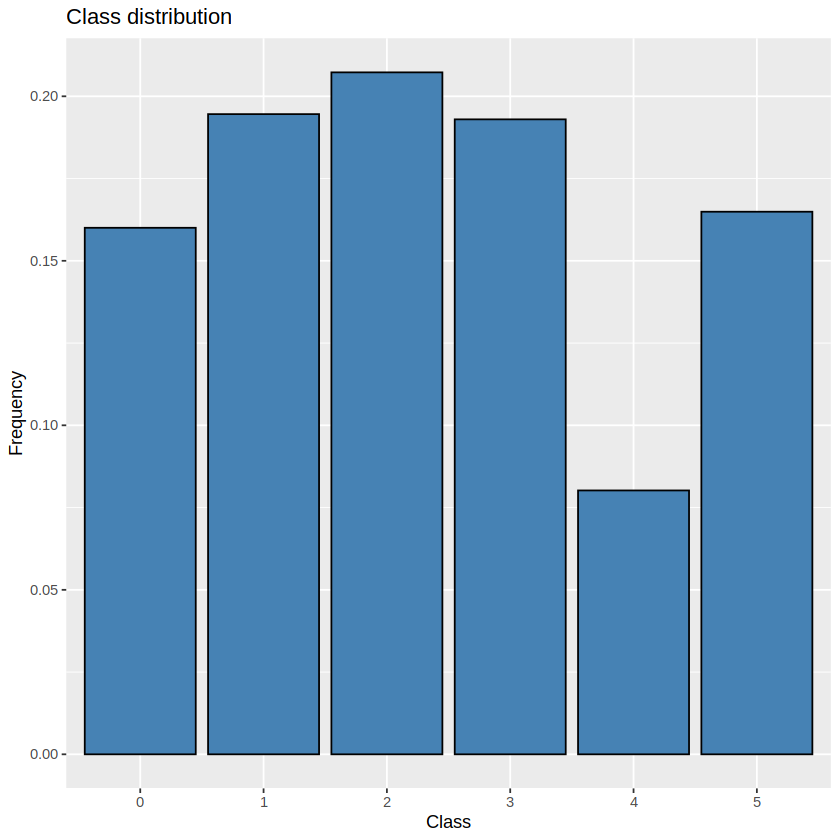

In [6]:
frequenze <- table(train$Labels)
frequenze_normalizzate <- frequenze / sum(frequenze)

df_hist <- as.data.frame(frequenze_normalizzate)
df_hist$classe <- as.numeric(rownames(df_hist))
colnames(df_hist) <- c("frequenza", "classe")

ggplot(data = df_hist, aes(x = classe, y = frequenza)) +
  geom_bar(stat = "identity", fill = "steelblue", color = "black") +
  labs(title = "Class distribution", x = "Frequency", y = "Class")+
  coord_flip()

### Model without any improvements or feature selection

#### Vocabulary

In [7]:
train_un <- TokenizeDF(train)
vocabulary <- ExtractVocabulary(train_un)
# labels
C <- sort(unique(train$Labels))

#### Training

In [8]:
priors <- Priors(train)
condprobs <- CondProb(train_un, vocabulary)

#### Token distribution (absolute frequency)

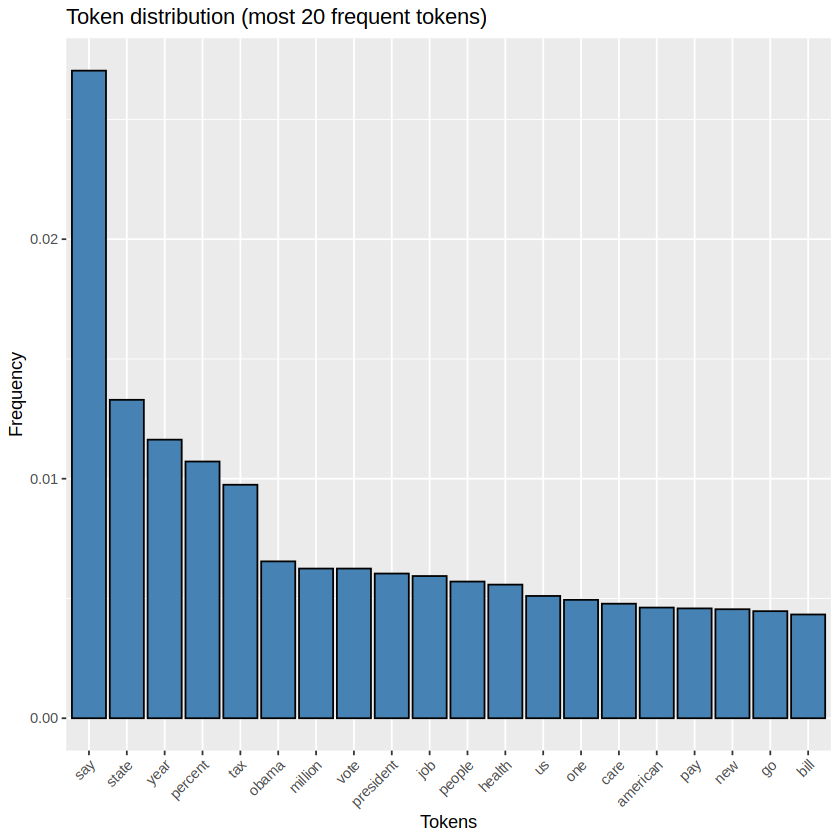

In [9]:
ShowTokensAbsoluteDistribution(train_un)

#### Predictions on test

In [10]:
predicted.labels <- ApplyMultinomialNBonDF(C, vocabulary, priors, condprobs, test)
test$Prediction <- predicted.labels

#### Results

In [11]:
results <- ConfusionMatrix(test$Labels, test$Prediction)
results

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3   4   5
         0  56  48  50  38  32  23
         1  75  89  64  57  56  56
         2 108 114 149 125  46  92
         3  71  94 112 103  28 100
         4   4   9   3   7  11   2
         5  29  47  38  51   9  52

Overall Statistics
                                          
               Accuracy : 0.2246          
                 95% CI : (0.2067, 0.2433)
    No Information Rate : 0.2031          
    P-Value [Acc > NIR] : 0.009017        
                                          
                  Kappa : 0.0471          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Sensitivity           0.16327  0.22195  0.35817  0.27034 0.060440  0.16000
Specificity           0.88798  0.81299  0.70282  0.75705 0.986602  0.89901
Pos Pred Value        0.22672  0.22418  0.23502

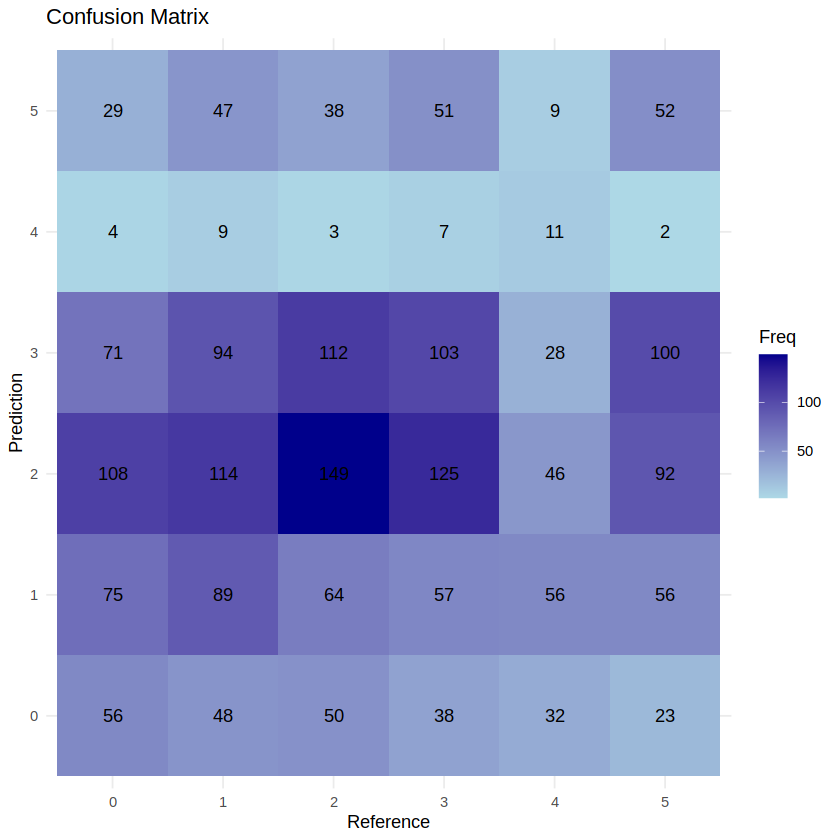

In [12]:
ShowConfusionMatrix(results)

### Model including tags within the Text column

In [13]:
# include tags
train$Text <- paste(train$Text, train$Text_Tag)

#### Vocabulary

In [14]:
train_un <- TokenizeDF(train)
vocabulary <- ExtractVocabulary(train_un)
# labels
C <- sort(unique(train$Labels))

#### Training

In [15]:
priors <- Priors(train)
condprobs <- CondProb(train_un, vocabulary)

#### Token distribution (absolute frequency)

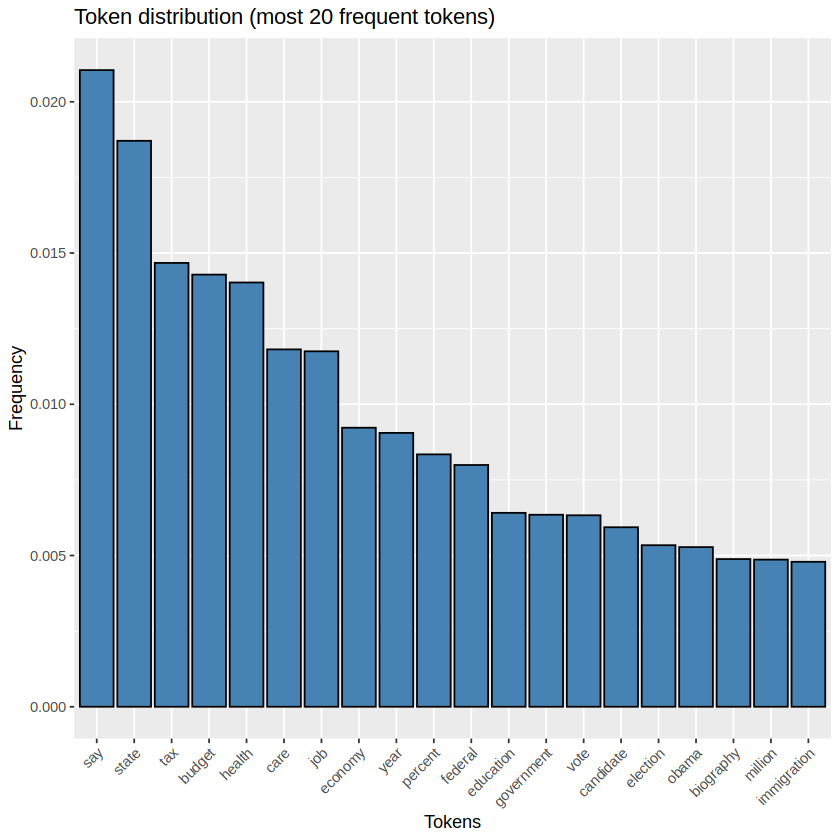

In [16]:
ShowTokensAbsoluteDistribution(train_un)

#### Predictions on test¶

In [17]:
predicted.labels <- ApplyMultinomialNBonDF(C, vocabulary, priors, condprobs, test)
test$Prediction <- predicted.labels

#### Results

In [18]:
results <- ConfusionMatrix(test$Labels, test$Prediction)
results

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3   4   5
         0  61  53  48  36  36  25
         1  67  88  61  54  49  51
         2 102 106 142 115  43  86
         3  70  90 112 107  27  97
         4   9  13   9   8  14   4
         5  34  51  44  61  13  62

Overall Statistics
                                          
               Accuracy : 0.2314          
                 95% CI : (0.2133, 0.2503)
    No Information Rate : 0.2031          
    P-Value [Acc > NIR] : 0.0009276       
                                          
                  Kappa : 0.058           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Sensitivity           0.17784  0.21945  0.34135  0.28084 0.076923  0.19077
Specificity           0.88387  0.82878  0.72304  0.76245 0.976956  0.88218
Pos Pred Value        0.23552  0.23784  0.23906

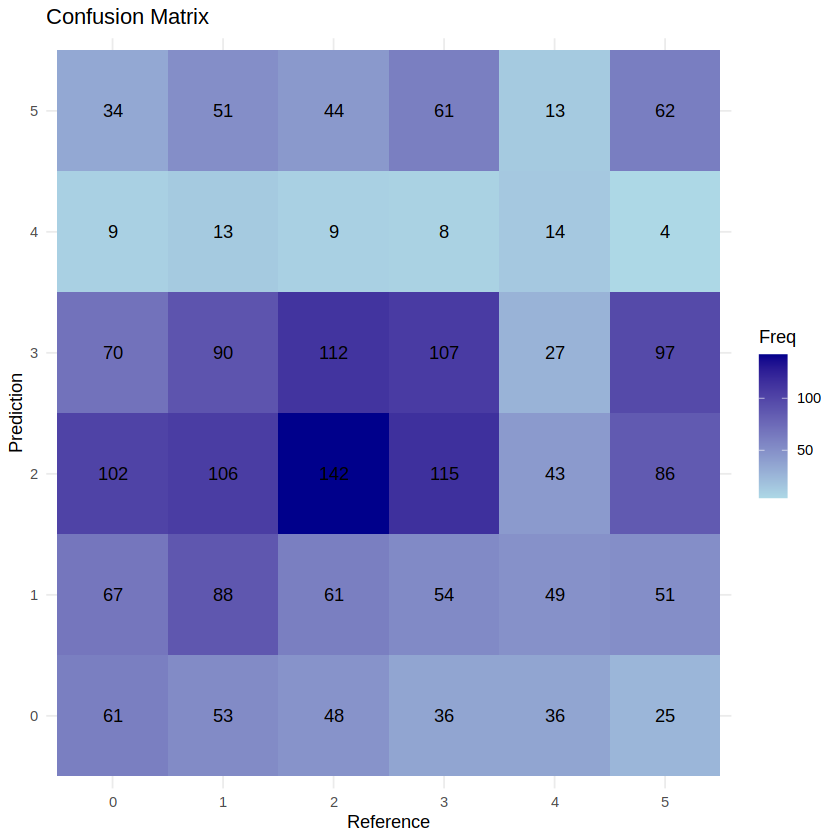

In [19]:
ShowConfusionMatrix(results)

We can see that the accuracy increase by about 0.6% (22.5% -> 23.1%) by considering also the tags as tokens.

### Model with feature selection (by thresholds)

#### Distribution of classes for each token
Now I want to find the frequency relatives to how much times each token appears in documents (without counting the repetitions) classiefied as i, for every i in C labels.

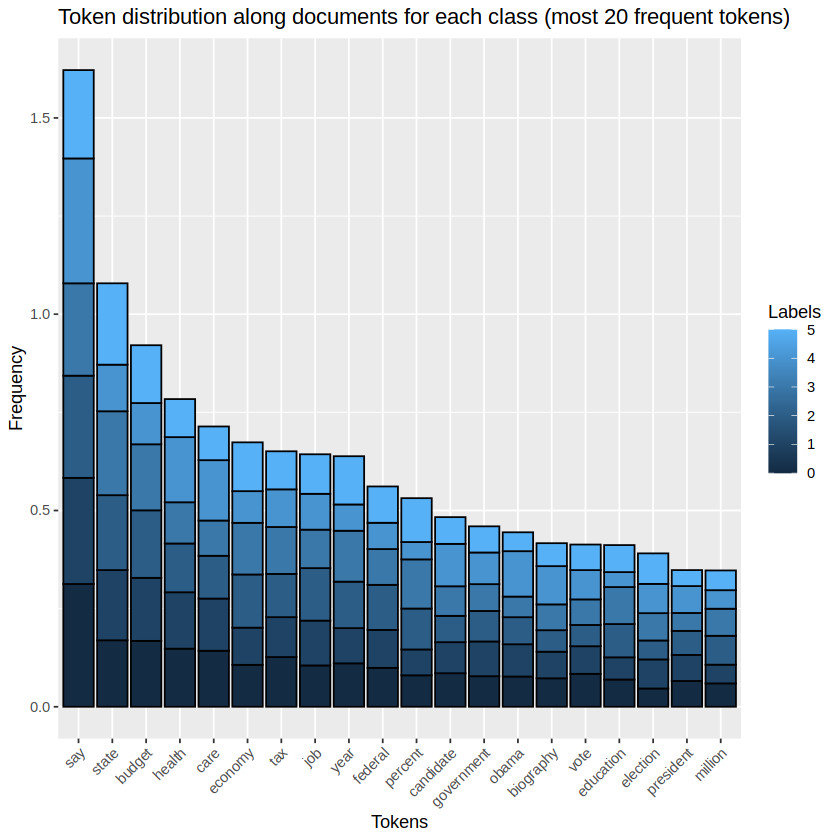

In [20]:
token_counting <- DistributionClassesForToken(train, vocabulary, C) 
token_counting %>% ShowDistributionClassesForToken()

Most frequent and less frequent tokens are the less significative. The maximum frequency is less than 50%, then an upper threshold is not necessary. I set a lower threshold of 3%.

#### Vocabulary (feature selection)

In [21]:
thr = 0.03
vocabulary <- unique(token_counting[token_counting$n >= thr,]$Tokens)

#### Training

In [22]:
# NB! train_un, labels, piors don't change
condprobs <- CondProb(train_un, vocabulary)

#### Predictions on test¶

In [23]:
predicted.labels <- ApplyMultinomialNBonDF(C, vocabulary, priors, condprobs, test)
test$Prediction <- predicted.labels

#### Results

In [24]:
results <- ConfusionMatrix(test$Labels, test$Prediction)
results

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3   4   5
         0  64  54  58  38  28  34
         1  69  93  63  62  58  53
         2 119 135 146 126  56 112
         3  76 104 124 133  31 107
         4   5   8   7   3   6   4
         5  10   7  18  19   3  15

Overall Statistics
                                          
               Accuracy : 0.2231          
                 95% CI : (0.2053, 0.2418)
    No Information Rate : 0.2031          
    P-Value [Acc > NIR] : 0.01376         
                                          
                  Kappa : 0.0425          
                                          
 Mcnemar's Test P-Value : < 2e-16         

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Sensitivity           0.18659  0.23192  0.35096  0.34908  0.03297 0.046154
Specificity           0.87566  0.81481  0.66422  0.73485  0.98553 0.966918
Pos Pred Value        0.23188  0.23367  0.21037

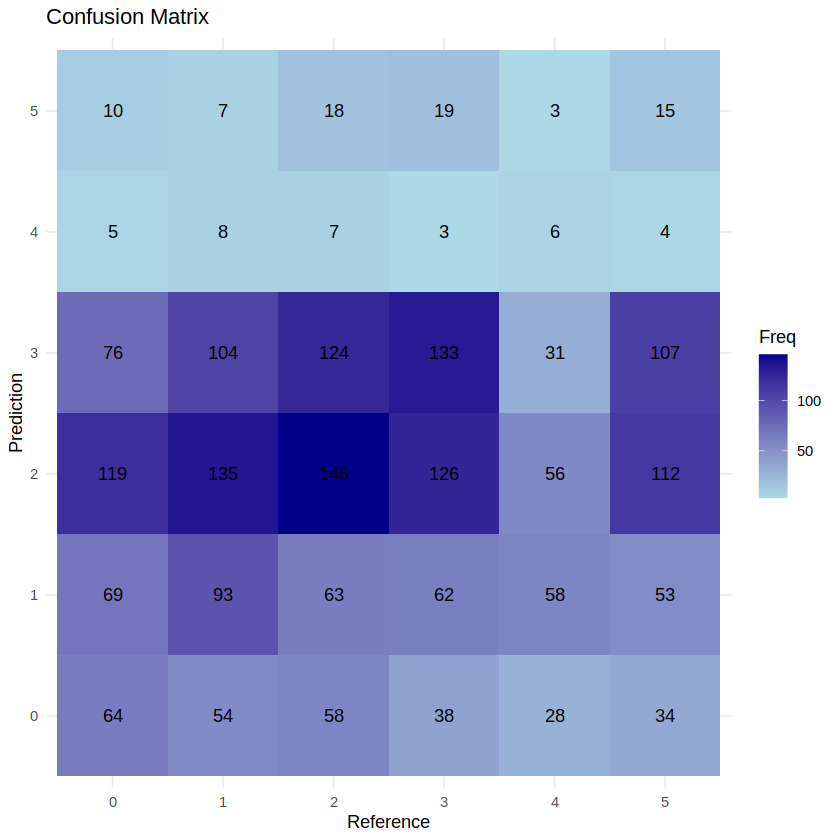

In [25]:
ShowConfusionMatrix(results)

The accuracy is decreased w.r.t. the case without the feature selection (23.1% -> 22.3%). From the confusion matrix one could see that the problem is clearly the class 4.

### Relabeling

### 5,3 -> 2 (True); 2,4 -> 1 (Maybe); 0,1 -> 0 (False)

### w/o feature selection

In [26]:
train_rl <- train
test_rl <- test
# change classes
## for train
tmp <- ifelse((train_rl$Labels == 5|train_rl$Labels == 3), 2, 0)
tmp <- tmp + ifelse((train_rl$Labels == 2|train_rl$Labels == 4), 1, 0)
tmp <- tmp + ifelse((train_rl$Labels == 0|train_rl$Labels == 1), 0, 0)
train_rl$Labels <- tmp
# for test
tmp <- ifelse((test_rl$Labels == 5|test_rl$Labels == 3), 2, 0)
tmp <- tmp + ifelse((test_rl$Labels == 2|test_rl$Labels == 4), 1, 0)
tmp <- tmp + ifelse((test_rl$Labels == 0|test_rl$Labels == 1), 0, 0)
test_rl$Labels <- tmp

# Classes
C <- sort(unique(train_rl$Labels))

#### Vocabulary

In [27]:
train_un <- TokenizeDF(train_rl)
vocabulary <- ExtractVocabulary(train_un)

#### Distribution of classes for each token

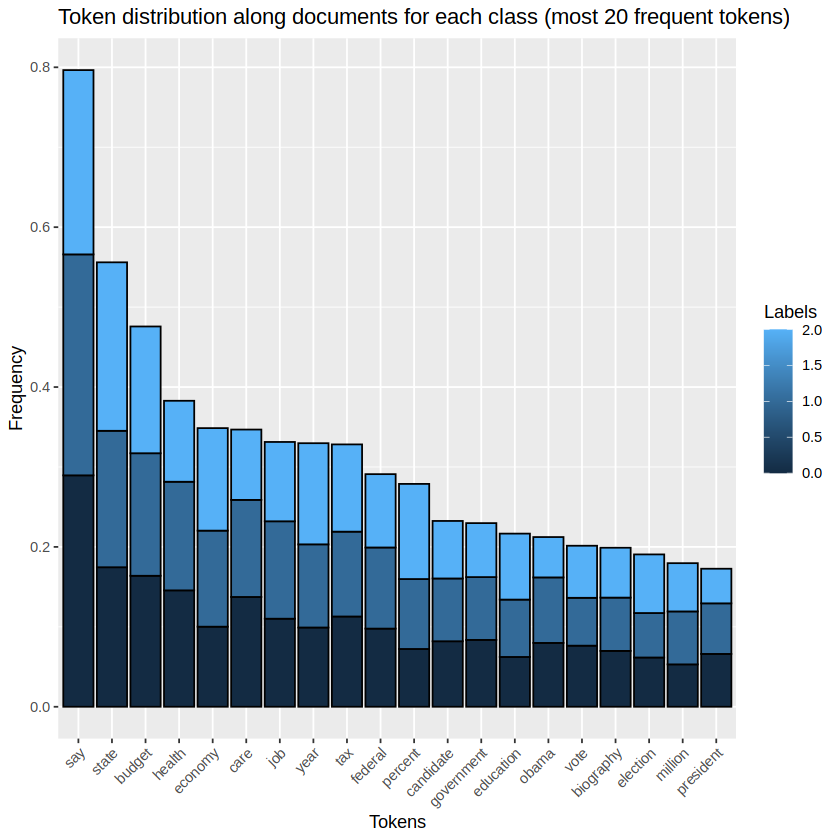

In [28]:
token_counting <- DistributionClassesForToken(train_rl, vocabulary, C) 
token_counting %>% ShowDistributionClassesForToken()

#### Training

In [29]:
priors <- Priors(train_rl)
condprobs <- CondProb(train_un, vocabulary)

#### Predictions on test

In [30]:
predicted.labels <- ApplyMultinomialNBonDF(C, vocabulary, priors, condprobs, test_rl)
test_rl$Prediction <- predicted.labels

#### Results

In [31]:
results <- ConfusionMatrix(test_rl$Labels, test_rl$Prediction)
results

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2
         0 307 217 219
         1 166 145  98
         2 271 236 389

Overall Statistics
                                          
               Accuracy : 0.4106          
                 95% CI : (0.3892, 0.4323)
    No Information Rate : 0.3633          
    P-Value [Acc > NIR] : 5.444e-06       
                                          
                  Kappa : 0.1058          
                                          
 Mcnemar's Test P-Value : 5.947e-15       

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.4126   0.2425   0.5510
Specificity            0.6656   0.8179   0.6222
Pos Pred Value         0.4132   0.3545   0.4342
Neg Pred Value         0.6651   0.7236   0.7248
Prevalence             0.3633   0.2920   0.3447
Detection Rate         0.1499   0.0708   0.1899
Detection Prevalence   0.3628   0.1997   0.4375
Balanced Accuracy      0.5391   0.5302   

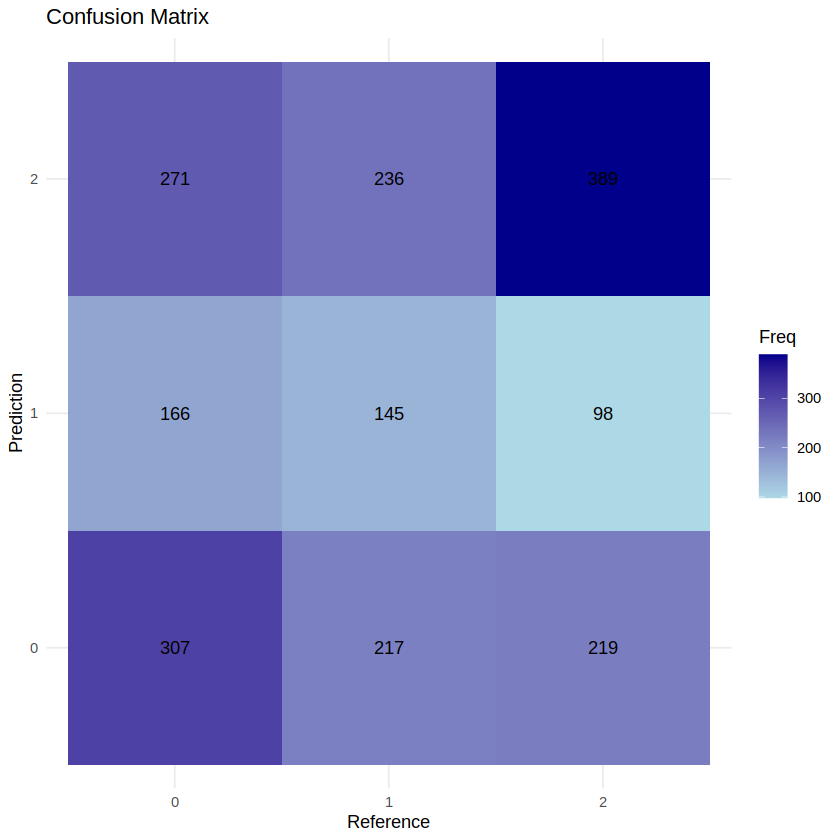

In [32]:
ShowConfusionMatrix(results)

### w/ feature selection (1%)

In [33]:
thr <- 0.01
vocabulary <- unique(token_counting[token_counting$n >= thr,]$Tokens)

#### Training

In [34]:
priors <- Priors(train_rl)
condprobs <- CondProb(train_un, vocabulary)

#### Predictions on test¶

In [35]:
predicted.labels <- ApplyMultinomialNBonDF(C, vocabulary, priors, condprobs, test_rl)
test_rl$Prediction <- predicted.labels

#### Results

In [36]:
results <- ConfusionMatrix(test_rl$Labels, test_rl$Prediction)
results

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2
         0 312 233 185
         1 105  88  54
         2 327 277 467

Overall Statistics
                                          
               Accuracy : 0.4233          
                 95% CI : (0.4018, 0.4451)
    No Information Rate : 0.3633          
    P-Value [Acc > NIR] : 1.256e-08       
                                          
                  Kappa : 0.1196          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.4194  0.14716   0.6615
Specificity            0.6794  0.89034   0.5499
Pos Pred Value         0.4274  0.35628   0.4360
Neg Pred Value         0.6722  0.71682   0.7554
Prevalence             0.3633  0.29199   0.3447
Detection Rate         0.1523  0.04297   0.2280
Detection Prevalence   0.3564  0.12061   0.5229
Balanced Accuracy      0.5494  0.51875   

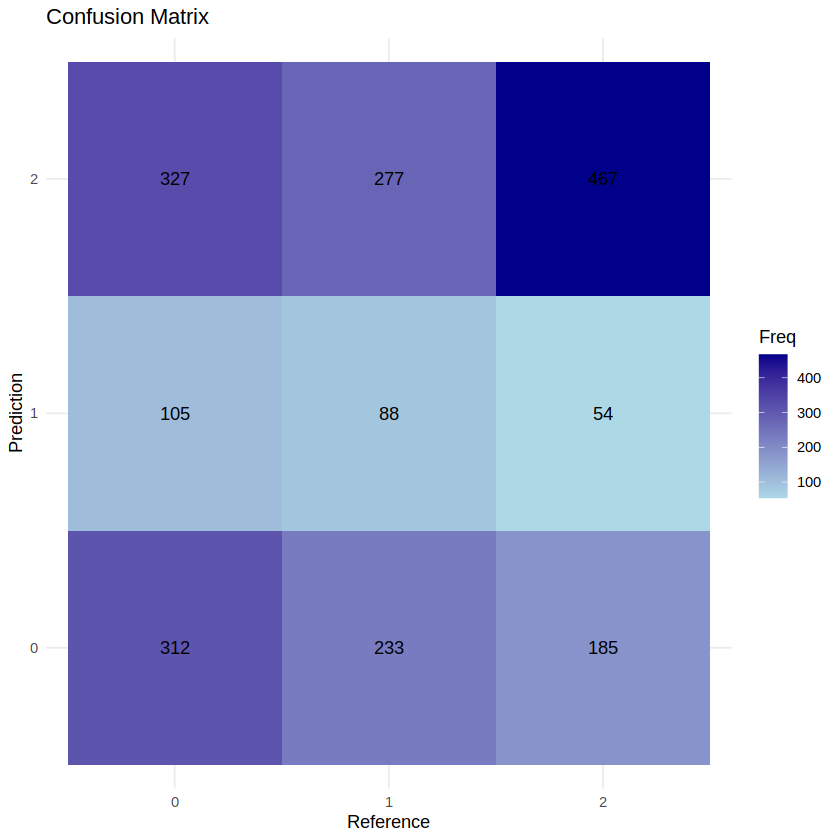

In [37]:
ShowConfusionMatrix(results)

### 5 -> 1 (True); 1 -> 0 (False)

### w/o feature selection

In [38]:
train_rl <- train[train$Labels == 5|train$Labels == 1,]
test_rl <- test[test$Labels == 5|test$Labels == 1,]
# labels
C <- sort(unique(train_rl$Labels))

#### Vocabulary 

In [39]:
train_un <- TokenizeDF(train_rl)
vocabulary <- ExtractVocabulary(train_un)

#### Distribution of classes for each token

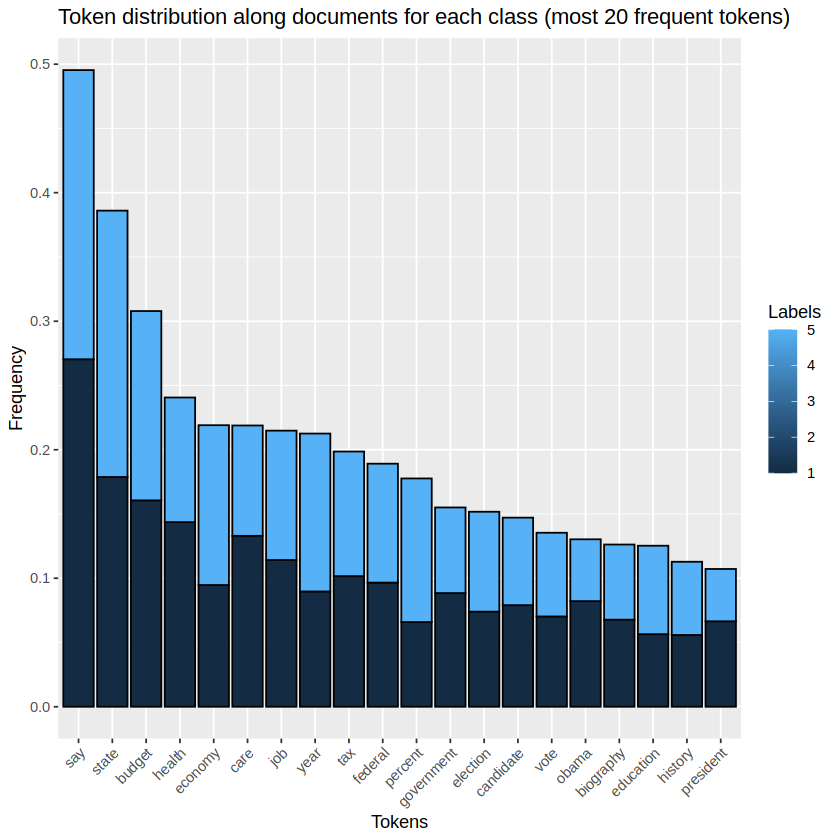

In [40]:
token_counting <- DistributionClassesForToken(train_rl, vocabulary, C) 
token_counting %>% ShowDistributionClassesForToken()

#### Training 

In [41]:
priors <- Priors(train_rl)
condprobs <- CondProb(train_un, vocabulary)

#### Predictions on test¶

In [42]:
predicted.labels <- ApplyMultinomialNBonDF(C, vocabulary, priors, condprobs, test_rl)
test_rl$Prediction <- predicted.labels

#### Results

In [43]:
results <- ConfusionMatrix(test_rl$Labels, test_rl$Prediction)
results

Confusion Matrix and Statistics

          Reference
Prediction   1   5
         1 225 140
         5 176 185
                                          
               Accuracy : 0.5647          
                 95% CI : (0.5278, 0.6012)
    No Information Rate : 0.5523          
    P-Value [Acc > NIR] : 0.26317         
                                          
                  Kappa : 0.129           
                                          
 Mcnemar's Test P-Value : 0.04896         
                                          
            Sensitivity : 0.5611          
            Specificity : 0.5692          
         Pos Pred Value : 0.6164          
         Neg Pred Value : 0.5125          
             Prevalence : 0.5523          
         Detection Rate : 0.3099          
   Detection Prevalence : 0.5028          
      Balanced Accuracy : 0.5652          
                                          
       'Positive' Class : 1               
                              

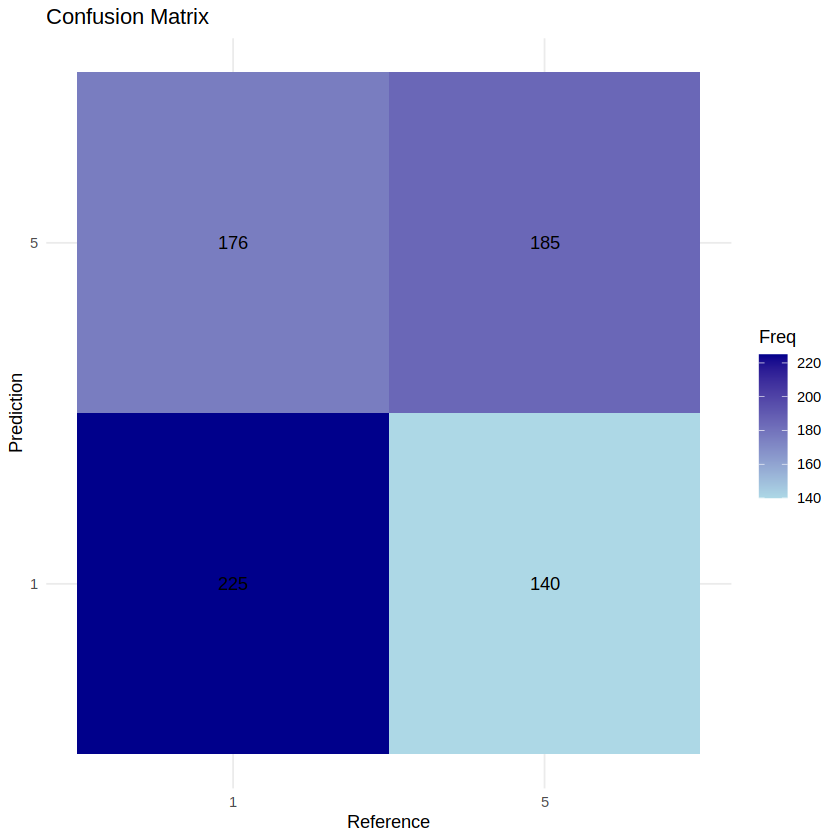

In [44]:
ShowConfusionMatrix(results)

### w/ feature selection (1%)

In [45]:
thr <- 0.01
vocabulary <- unique(token_counting[token_counting$n >= thr,]$Tokens)

#### Training 

In [46]:
priors <- Priors(train_rl)
condprobs <- CondProb(train_un, vocabulary)

#### Predictions on test¶

In [47]:
predicted.labels <- ApplyMultinomialNBonDF(C, vocabulary, priors, condprobs, test_rl)
test_rl$Prediction <- predicted.labels

#### Results

In [48]:
results <- ConfusionMatrix(test_rl$Labels, test_rl$Prediction)
results

Confusion Matrix and Statistics

          Reference
Prediction   1   5
         1 238 118
         5 163 207
                                          
               Accuracy : 0.6129          
                 95% CI : (0.5764, 0.6485)
    No Information Rate : 0.5523          
    P-Value [Acc > NIR] : 0.0005513       
                                          
                  Kappa : 0.2275          
                                          
 Mcnemar's Test P-Value : 0.0086695       
                                          
            Sensitivity : 0.5935          
            Specificity : 0.6369          
         Pos Pred Value : 0.6685          
         Neg Pred Value : 0.5595          
             Prevalence : 0.5523          
         Detection Rate : 0.3278          
   Detection Prevalence : 0.4904          
      Balanced Accuracy : 0.6152          
                                          
       'Positive' Class : 1               
                              

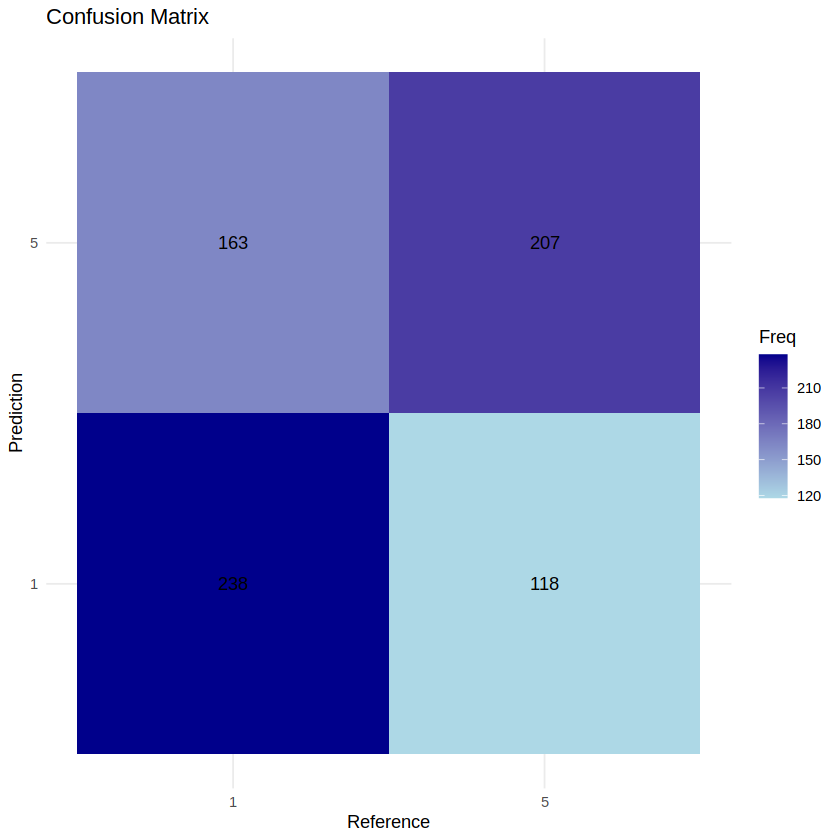

In [49]:
ShowConfusionMatrix(results)

We can see that in this case the accuracy grows from 56.5% to 61.3% by applying a feature selection with a lower threshold of 1%. The model seems working better with binary classes.

## Dataset 2

### Import the dataset and divide it into train and test sets

In [50]:
raw <- read.csv('/home/marco/Desktop/Magistrale/Advanced Statistics/Project/fake-news/train.csv')
# rename colums accordingly to the previous dataset
colnames(raw)[4] ="Text"
colnames(raw)[5] ="Labels"

#remove the useless columns
raw <- raw[,4:5]

#remove NA values from the Labels
raw <- na.omit(raw)

# take the first n rows
#n <- 1000
#raw <- raw[1:n,]

# fraction of data in the training set
train_size <- 0.8

tmp <- as.integer(nrow(raw)*train_size)
train <- raw[1:tmp,]
test <- raw[(tmp+1):nrow(raw),]

### Class distribution

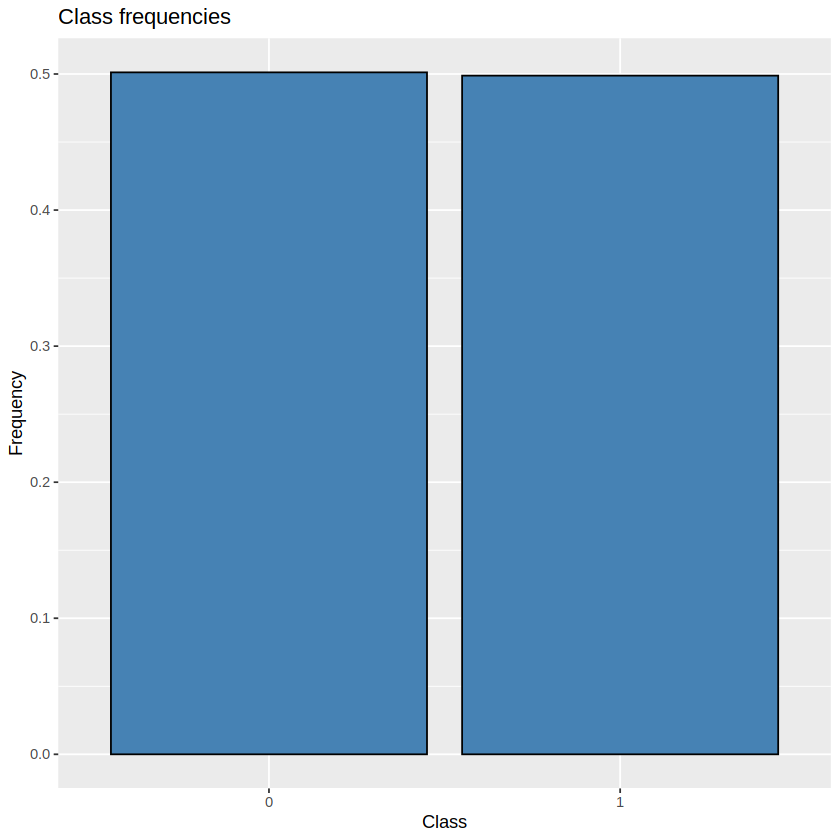

In [51]:
frequenze <- table(train$Labels)
frequenze_normalizzate <- frequenze / sum(frequenze)

df_hist <- as.data.frame(frequenze_normalizzate)
df_hist$classe <- as.numeric(rownames(df_hist))
colnames(df_hist) <- c("frequenza", "classe")

ggplot(data = df_hist, aes(x = classe, y = frequenza)) +
  geom_bar(stat = "identity", fill = "steelblue", color = "black") +
  labs(title = "Class frequencies", x = "Frequency", y = "Class")+
  coord_flip()

commento sul fatto che sono molto più equilibrate rispetto al caso di prima

### Model without any improvements or feature selection

#### Vocabulary

In [52]:
train_un <- TokenizeDF(train)
vocabulary <- ExtractVocabulary(train_un)
# labels
C <- sort(unique(train$Labels))

#### Training

In [54]:
priors <- Priors(train)
condprobs <- CondProb(train_un, vocabulary)

#### Token distribution (absolute frequency)

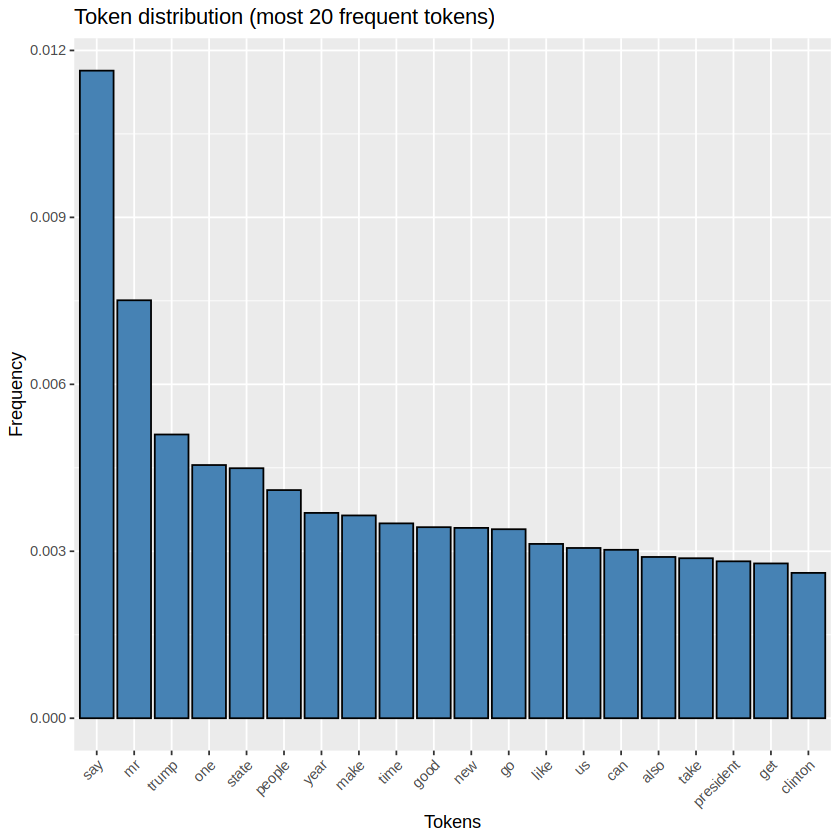

In [55]:
ShowTokensAbsoluteDistribution(train_un)

#### Predictions on test¶

In [60]:
predicted.labels <- ApplyMultinomialNBonDF(C, vocabulary, priors, condprobs, test)
test$Prediction <- predicted.labels

#### Results

In [61]:
results <- ConfusionMatrix(test$Labels, test$Prediction)
results

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1972  383
         1   75 1730
                                        
               Accuracy : 0.8899        
                 95% CI : (0.88, 0.8993)
    No Information Rate : 0.5079        
    P-Value [Acc > NIR] : < 2.2e-16     
                                        
                  Kappa : 0.7803        
                                        
 Mcnemar's Test P-Value : < 2.2e-16     
                                        
            Sensitivity : 0.9634        
            Specificity : 0.8187        
         Pos Pred Value : 0.8374        
         Neg Pred Value : 0.9584        
             Prevalence : 0.4921        
         Detection Rate : 0.4740        
   Detection Prevalence : 0.5661        
      Balanced Accuracy : 0.8911        
                                        
       'Positive' Class : 0             
                                        

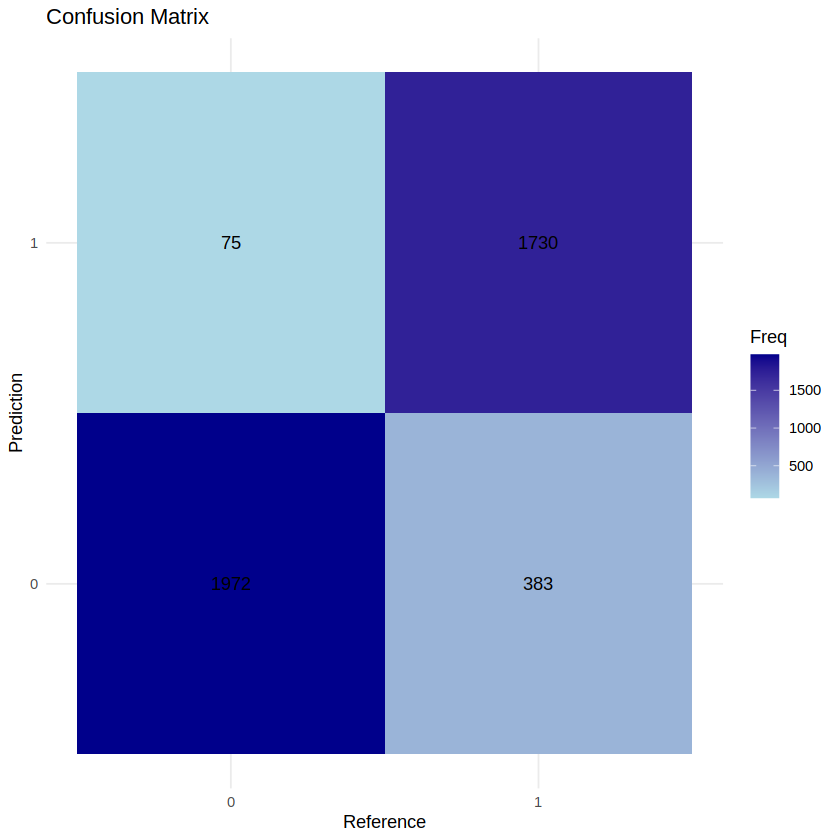

In [62]:
ShowConfusionMatrix(results)

### Model with feature selection (by thresholds)

#### Distribution of classes for each token
Now I want to find the frequency relatives to how much times each token appears in documents (without counting the repetitions) classiefied as i, for every i in C labels.

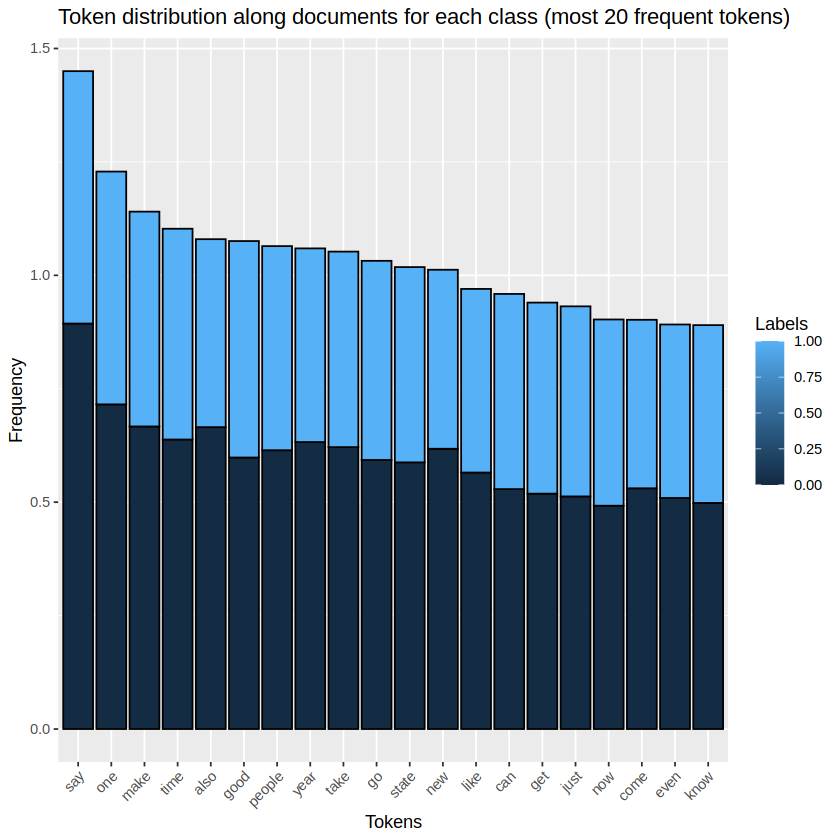

In [63]:
token_counting <- DistributionClassesForToken(train, vocabulary, C) 
token_counting %>% ShowDistributionClassesForToken()

Most frequent and less frequent tokens are the less significative. I set a lower threshold of 5% and an higher of 95%.

#### Vocabulary (feature selection)

In [121]:
l_thr <- 0.01
h_thr <- 1
vocabulary <- unique(token_counting[(token_counting$n >= l_thr & token_counting$n <= h_thr),]$Tokens)

#### Training

In [122]:
# NB! train_un, labels, piors don't change
condprobs <- CondProb(train_un, vocabulary)

#### Predictions on test¶

In [123]:
predicted.labels <- ApplyMultinomialNBonDF(C, vocabulary, priors, condprobs, test)
test$Prediction <- predicted.labels

#### Results

In [124]:
results <- ConfusionMatrix(test$Labels, test$Prediction)
results

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1973  567
         1   74 1546
                                          
               Accuracy : 0.8459          
                 95% CI : (0.8346, 0.8568)
    No Information Rate : 0.5079          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6929          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9638          
            Specificity : 0.7317          
         Pos Pred Value : 0.7768          
         Neg Pred Value : 0.9543          
             Prevalence : 0.4921          
         Detection Rate : 0.4743          
   Detection Prevalence : 0.6106          
      Balanced Accuracy : 0.8478          
                                          
       'Positive' Class : 0               
                        

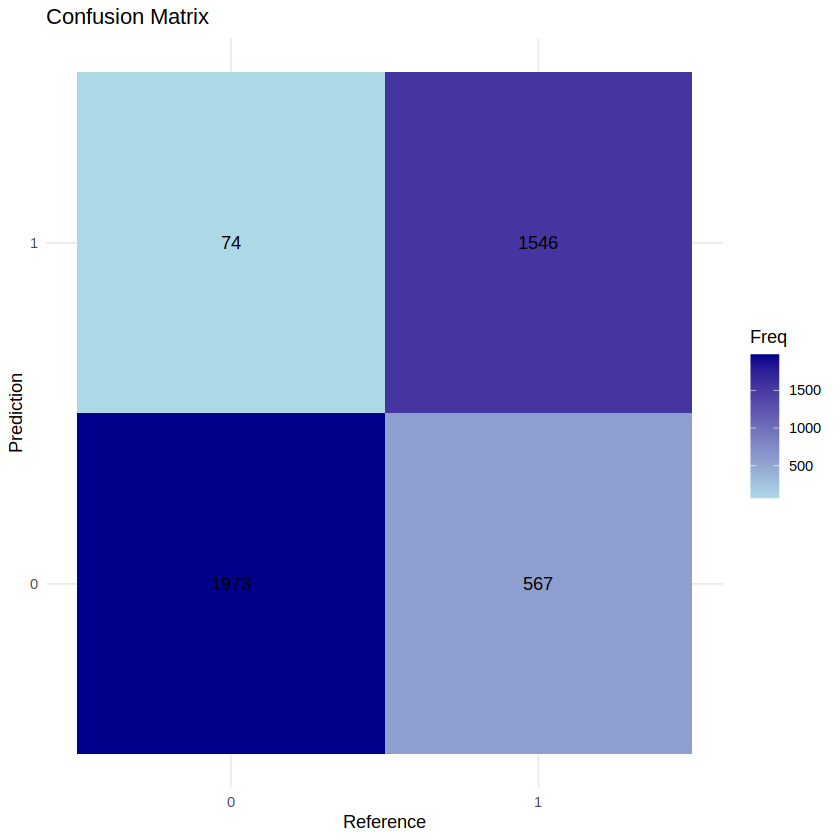

In [125]:
ShowConfusionMatrix(results)